## Time sorting using numpy argsort versus sorted

In [1]:
import timeit
import numpy as np

In [4]:
def test1():
    list1 = [  8,  4,  5,  1,  3,  9, 13,  7, 10,  1, 60,  0,  4, 11,  2, 6]
    list2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
    npl1 = np.array(list1)
    npl2 = np.array(list2)
    list3 = [x for _, x in sorted(zip(list1,list2))]
    
def test2():
    list1 = [  8,  4,  5,  1,  3,  9, 13,  7, 10,  1, 60,  0,  4, 11,  2, 6]
    list2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
    npl1 = np.array(list1)
    npl2 = np.array(list2)
    inds = npl1.argsort()
    npl3 = npl2[inds]

print(timeit.timeit('test1()', setup="from __main__ import test1", number=1000000))
print(timeit.timeit('test2()', setup="from __main__ import test2", number=1000000))

6.13684636898688
4.024672788000316


In [9]:
print(timeit.timeit('np.linspace(0.1, 6.0, 50)', setup="import numpy as np", number=1000000))
print(timeit.timeit('np.linspace(0.1, 6.0, 50, dtype=float)', setup="import numpy as np", number=1000000))

8.201054332006606
8.228587093995884


In [14]:
from draculab import *
net_params = {'min_delay' : 0.1, 'min_buff_size' : 3, 'rtol':1e-4, 'atol':1e-4 } 
net = network(net_params)
inp_params = {'type' : unit_types.source, 'init_val' : 0., 'tau_fast' : 0.2, 'function' : lambda x: None}
units = net.create(8, inp_params)

In [18]:
unit_objects = [net.units[u] for u in units]
np.array(unit_objects)

array([<units.source object at 0x7fdc0d3c5908>,
       <units.source object at 0x7fdc0d3c5a90>], dtype=object)

In [19]:
list1 = [  8,  4,  5,  1,  3,  9, 13,  7, 10,  1, 60,  0,  4, 11,  2, 6]
list2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
npl1 = np.array(list1)
npl2 = np.array(list2)
inds = npl1.argsort()
npl3 = npl2[inds]

In [25]:
np.linalg.norm(np.random.uniform(-2,3,4))

2.9942718355010336

## Time part of the linear interpolation algorithm in python/numpy VS theano

In [1]:
import timeit
import time
import numpy as np
import theano.tensor as T
from theano import function

In [2]:
# python/numpy
def get_base(time, l, h, bs):
        """ Part of unit.get_act to compare against theano.
        """
        time = min( max(time, l), h ) # clipping 'time'
        frac = (time-l)/(h-l)
        return (np.floor(frac*(bs-1))) # biggest index s.t. times[index] <= time


In [3]:
# theano
t,l,h,bs = T.scalars('t','l','h','bs')
base = ( ( T.minimum( T.maximum(t, l), h) - l ) / (h - l) ) * (bs-1) 
th_get_base = function([t,l,h,bs], base)

In [5]:
l = 0.
h = 10.
bs = 100.
times = np.linspace(-2.,12.,100000)
# time the numpy/python version
start_time = time.time()
for t in times:
    b = get_base(t, l, h, bs)
print("numpy implementation: %s" % (time.time() - start_time))
# time the theano version
start_time = time.time()
for t in times:
    b = th_get_base(t, l, h, bs)
print("theano implementation: %s" % (time.time() - start_time))

numpy implementation: 0.17931175231933594
theano implementation: 3.758284091949463


## Time the 3 interpolation types, compare accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

10 loops, best of 3: 131 ms per loop
1000 loops, best of 3: 332 µs per loop
10000 loops, best of 3: 127 µs per loop
4.41683993269e-08


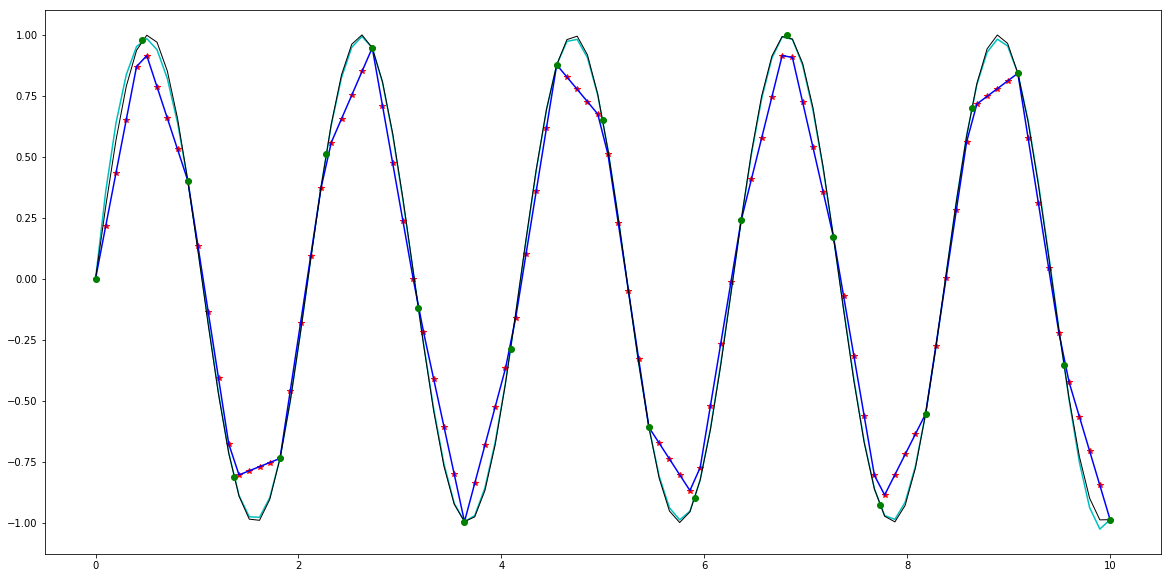

In [2]:
times = np.linspace(0,10,23)
buffer = np.sin(3.*times)
buff_size = len(buffer)
time_bit = times[1]-times[0] + 1e-9

def interp1(time):
    return interp1d(times, buffer, kind='cubic', bounds_error=False, fill_value=0.)(time)

def interp2(time):
    time = min( max(time,times[0]), times[-1] )
    frac = (time-times[0])/(times[-1]-times[0])  
    base = int(np.floor(frac*(buff_size-1))) 
    frac2 = ( time-times[base] ) / ( times[min(base+1,buff_size-1)] - times[base] + 1e-8 )
    return buffer[base] + frac2 * ( buffer[min(base+1,buff_size-1)] - buffer[base] )  
    
def interp3(time):
    #time = min( max(time,times[0]), times[-1] )
    base, rem = divmod(time-times[0], time_bit) 
    base =  max(0, min(int(base), buff_size-2)) 
    #base = int(base)
    frac2 = rem/time_bit
    return buffer[base] + frac2 * ( buffer[base+1] - buffer[base] )  

tgrid = np.linspace(0.,10.,100)
%timeit np.array([interp1(t) for t in tgrid])
%timeit np.array([interp2(t) for t in tgrid])
%timeit np.array([interp3(t) for t in tgrid])
val1 = np.array([interp1(t) for t in tgrid])
val2 = np.array([interp2(t) for t in tgrid])
val3 = np.array([interp3(t) for t in tgrid])

valdiff = max(val2-val3)
print(valdiff)
fig = plt.figure(figsize=(20,10))
plt.plot(tgrid, val1, 'c', tgrid, val2, 'r*', tgrid, val3, 'b')
plt.plot(tgrid, np.sin(3.*tgrid), 'k', linewidth=1)
plt.plot(times, buffer, 'go')
plt.show()

## Using negative indices with numpy arrays

In [15]:
import timeit
print(timeit.timeit('a[98]', setup="import numpy as np; a = np.arange(100)", number=10000000))
print(timeit.timeit('a[-2]', setup="import numpy as np; a = np.arange(100)", number=10000000))

0.4505364340147935
0.4637470029992983


## Extracting a submatrix by replacing a mask vs using a structured index

In [3]:
# FIRST WE USE THE STRUCTURED INDEX
import numpy.ma as ma
y = ma.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], mask=[[1,0,0,0],[1,1,0,0],[0,0,0,0]], hard_mask=True)
print(y)
idx = [[0,0],[1,1],[2,2]], [[1,2],[2,3],[0,1]]
%timeit v = y[ idx ].data
v = y[ idx ].data
print(v)

[[-- 2 3 4]
 [-- -- 7 8]
 [9 10 11 12]]
15.9 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[[ 2  3]
 [ 7  8]
 [ 9 10]]


In [24]:
# UNMASKED ARRAY
import numpy as np
y = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
print(y)
idx = [[0,0],[1,1],[2,2]], [[1,2],[2,3],[0,1]]
%timeit v = y[ idx ]
y[ idx ]

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
3.1 µs ± 296 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


array([[ 2,  3],
       [ 7,  8],
       [ 9, 10]])

In [7]:
# NOW ASSIGN A MASK AND USE IT
y = ma.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], mask=[[1,0,0,0],[1,1,0,0],[0,0,0,0]])
y.mask = [[False,True,True,False],[False,False,True,True],[True,True,False,False]]
%timeit y.mask = [[False,True,True,False],[False,False,True,True],[True,True,False,False]]
%timeit y[y.mask].data.reshape(3,2)

2.65 µs ± 9.75 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.2 µs ± 17 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
# PERHAPS THE FASTEST OPTION IS TO USE A 1-D INDEX ON A FLATTENED ARRAY
import numpy as np
y = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
mask = [False,True,True,False,False,False,True,True,True,True,False,False]
%timeit y.flatten()[mask].reshape(3,2)
y.flatten()[mask].reshape(3,2)

1.63 µs ± 8.91 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


array([[ 2,  3],
       [ 7,  8],
       [ 9, 10]])

## Copy versus assignment

In [13]:
import numpy as np
A = np.arange(10000).reshape(100,100)
B = np.arange(10000).reshape(100,100)

In [14]:
%timeit A = B

15.1 ns ± 0.00336 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [15]:
%timeit np.copyto(A, B)

1.6 µs ± 9.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
